In [11]:
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from EtaInterpolationFunctions import *


## A simple example
Mapping a 2D distribution to a uniform distribution using different interpolation methods.


Original x: mean=0.481, std=0.172
Original y: mean=0.522, std=0.174


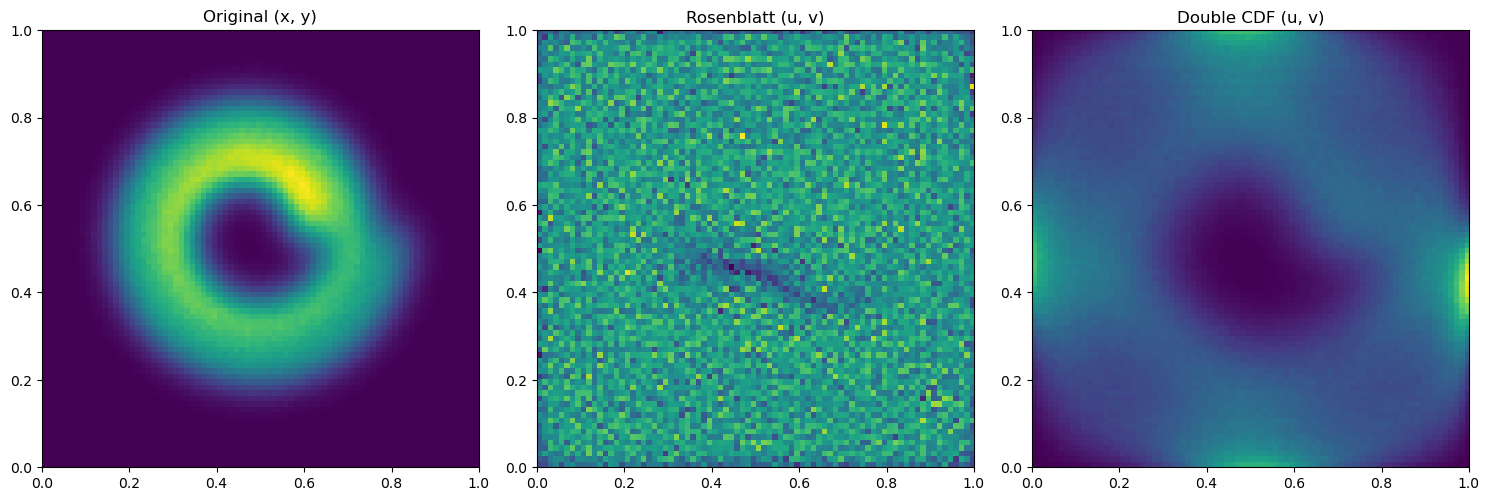

In [ ]:
rng = np.random.default_rng(42)
n = 10_000_000 # number of samples

# non-uniform 2D distribution: spiral with noise
theta = rng.uniform(0, 4*np.pi, size=n)
r = 0.3 + 0.4 * (theta / (4*np.pi))  # 螺旋半径从 0.3 到 0.7
x_raw = r * np.cos(theta) + 0.1 * rng.normal(size=n)
y_raw = r * np.sin(theta) + 0.1 * rng.normal(size=n)

# normalize to [0, 1]
x = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())
y = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

# build 2D histogram
nBins = 80
H, _, _ = np.histogram2d(x, y, bins=nBins, range=[[0,1],[0,1]])
H = H.astype(int)

# build LUT
X_tab, Y_tab = build_xy_lut_Rosenblatt(H)
u, v = bilinear_xy_lookup(x, y, X_tab, Y_tab)
H_uv = np.histogram2d(u, v, bins=nBins, range=[[0,1],[0,1]])[0]
X_tab2, Y_tab2 = build_xy_lut_DoubleCDF(H)
u2, v2 = bilinear_xy_lookup(x, y, X_tab2, Y_tab2)
H_uv2 = np.histogram2d(u2, v2, bins=nBins, range=[[0,1],[0,1]])[0]

# map to (u, v)
u, v = bilinear_xy_lookup(x, y, X_tab, Y_tab)

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(H.T, origin='lower', extent=[0,1,0,1])
axs[0].set_title("Original (x, y)")
axs[0].set_aspect('equal')

axs[1].imshow(H_uv.T, origin='lower', extent=[0,1,0,1])
axs[1].set_title("Rosenblatt (u, v)")

axs[2].imshow(H_uv2.T, origin='lower', extent=[0,1,0,1])
axs[2].set_title("Double CDF (u, v)")
axs[2].set_aspect('equal')
axs[2].set_xlim(0,1); axs[2].set_ylim(0,1)



plt.tight_layout()
plt.show()

## Generation of eta interpolation lookup tables

sum events = 10000000
mean etaX: 0.5000
mean etaY: 0.5001
nonuniformity = 976.0355


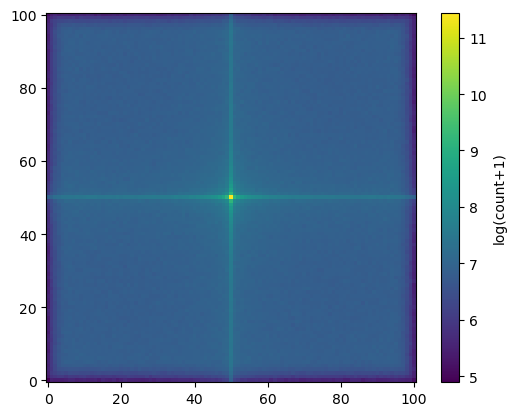

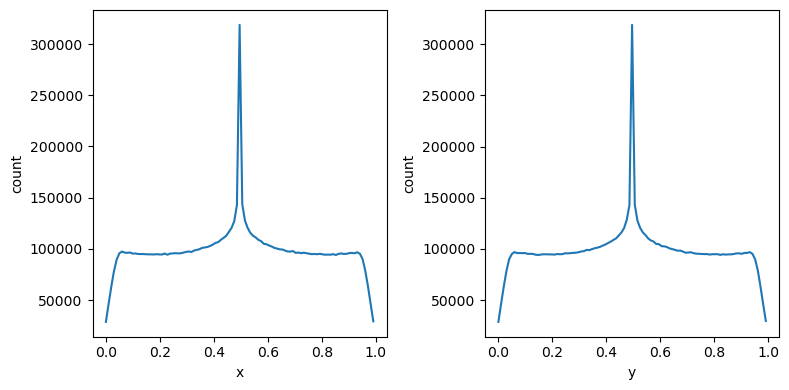

In [13]:
### generate qc2d histogram for lookup table generation
nBins = 101
sampleFileList = glob('/mnt/sls_det_storage/moench_data/MLXID/Samples/15keV_Moench040_150V_*.npz')
eta_2dhist = np.zeros((nBins, nBins), dtype=int)
for sampleFile in sampleFileList:
    samples = np.load(sampleFile)['samples'][:, 1:-1, 1:-1]
    # noises = np.random.normal(0, 0.3, samples.shape)
    # samples += noises
    sum = np.sum(samples, axis=(1,2))
    eta_xs = np.sum(samples[:, :, :], axis=1) ### integrate along y axis
    eta_xs *= np.arange(-1, 2) + 0.5
    eta_xs = np.sum(eta_xs, axis=1)/sum
    
    eta_ys = np.sum(samples[:, :, :], axis=2) ### integrate along x axis
    eta_ys *= np.arange(-1, 2) + 0.5
    eta_ys = np.sum(eta_ys, axis=1)/sum

    np.add.at(eta_2dhist, (np.clip((eta_xs*nBins).astype(int), 0, nBins - 1), np.clip((eta_ys*nBins).astype(int), 0, nBins - 1)), 1)
print(f'sum events = {np.sum(eta_2dhist)}')
averageEtaX = np.sum(np.arange(nBins)*np.sum(eta_2dhist, axis=1))/np.sum(eta_2dhist)/nBins + 1/nBins/2 ### add half bin shift
averageEtaY = np.sum(np.arange(nBins)*np.sum(eta_2dhist, axis=0))/np.sum(eta_2dhist)/nBins + 1/nBins/2 ### add half bin shift
print(f'mean etaX: {averageEtaX:.4f}')
print(f'mean etaY: {averageEtaY:.4f}')

nonuniformity = np.sqrt(np.mean((eta_2dhist - np.mean(eta_2dhist))**2))
print(f'nonuniformity = {nonuniformity:.4f}')

### plot qc2d histogram in a log scale
plt.imshow(np.log1p(eta_2dhist+1), origin='lower')
plt.colorbar(label='log(count+1)')
### project along x and y axis
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(np.arange(nBins)/nBins, np.sum(eta_2dhist, axis=1))
plt.xlabel('x')
plt.ylabel('count')
plt.subplot(1,2,2)
plt.plot(np.arange(nBins)/nBins, np.sum(eta_2dhist, axis=0))
plt.xlabel('y')
plt.ylabel('count')
plt.tight_layout()
plt.show()

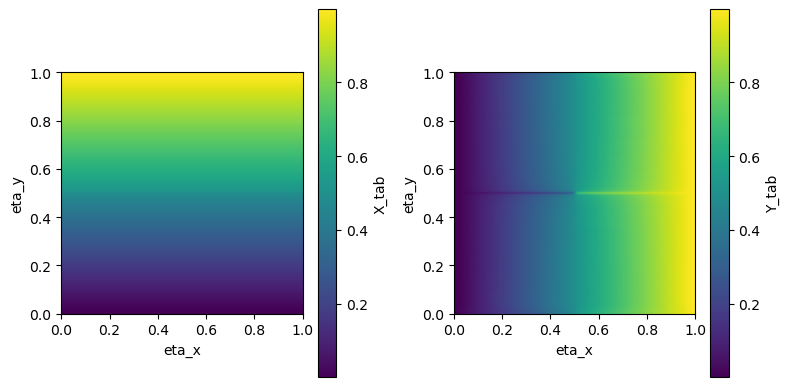

In [14]:
### build xy lookup table and plot
X_tab, Y_tab = build_xy_lut_Rosenblatt(eta_2dhist)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(X_tab, origin='lower', extent=(0,1,0,1))
plt.xlabel('eta_x')
plt.ylabel('eta_y')
plt.colorbar(label='X_tab')
plt.subplot(1,2,2)
plt.imshow(Y_tab, origin='lower', extent=(0,1,0,1))
plt.xlabel('eta_x')
plt.ylabel('eta_y')
plt.colorbar(label='Y_tab')
plt.tight_layout()
plt.show()

## Interpolate using uv lookup table
1. Save the residuals of x and y

sum events = 10000000.0
nonuniformity = 610.3487


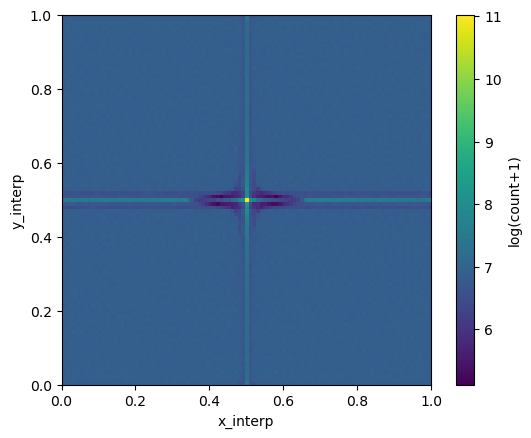

In [15]:
### interpolate using uv lookup table
sampleFileList = glob('/mnt/sls_det_storage/moench_data/MLXID/Samples/15keV_Moench040_150V_*.npz')
interpolated_2d = np.zeros((nBins, nBins), dtype=float)
residuls_x = []
residuls_y = []
x, y, z = [], [], []

for idx, sampleFile in enumerate(sampleFileList):
    samples = np.load(sampleFile)['samples'][:, 1:-1, 1:-1]
    labels = np.load(sampleFile)['labels']
    xs, ys = labels[:, 0], labels[:, 1]
    x.extend(labels[:, 0])
    y.extend(labels[:, 1])
    z.extend(labels[:, 2])

    # noises = np.random.normal(0, 0.3, samples.shape)
    # samples += noises
    sum = np.sum(samples, axis=(1,2))
    eta_xs = np.sum(samples, axis=1) ### integrate along y axis
    eta_xs *= np.arange(-1, 2)
    eta_xs = np.sum(eta_xs, axis=-1)/sum + 0.5
    
    eta_ys = np.sum(samples, axis=2) ### integrate along x axis
    eta_ys *= np.arange(-1, 2)
    eta_ys = np.sum(eta_ys, axis=-1)/sum + 0.5

    x_interp, y_interp = bilinear_xy_lookup(eta_xs, eta_ys, X_tab, Y_tab)
    # x_interp, y_interp = xy_lookup(eta_xs, eta_ys, X_tab, Y_tab)

    np.add.at(interpolated_2d, (np.clip((x_interp*nBins).astype(int), 0, nBins - 1), np.clip((y_interp*nBins).astype(int), 0, nBins - 1)), 1)

    residuls_x.extend(x_interp - (xs-2))
    residuls_y.extend(y_interp - (ys-2))
    # print(u)
    # print(xs-2)
print(f'sum events = {np.sum(interpolated_2d)}')
plt.imshow(np.log1p(interpolated_2d), origin='lower', extent=(0,1,0,1))
plt.xlabel('x_interp')
plt.ylabel('y_interp')
plt.colorbar(label='log(count+1)')

nonuniformity = np.sqrt(np.mean((interpolated_2d - np.mean(interpolated_2d))**2))
print(f'nonuniformity = {nonuniformity:.4f}')

## Check further interpolation results
1. Residuals: 1D distributions, and RMS vs absortion depth (z)
2. Distribution of spatial resoltuion in 5*5 subpixel array
3. Plot one simulation sample

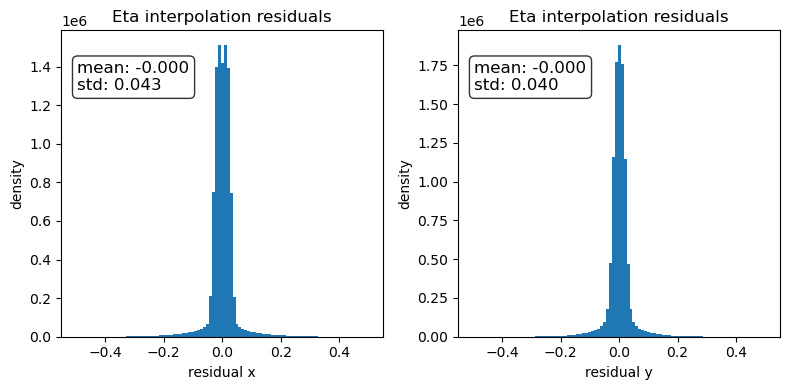

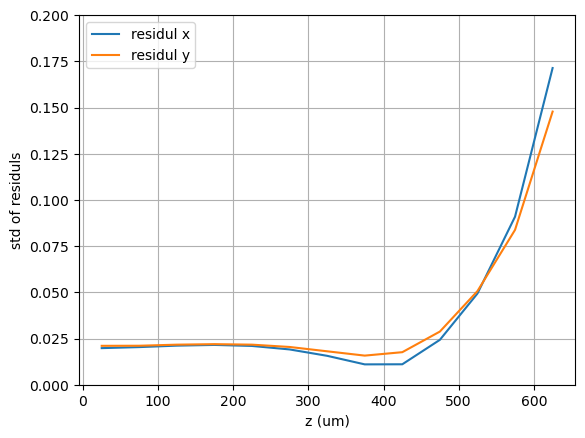

In [16]:
### plot residul_x and histogram
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
### residual_x histogram
plt.hist(residuls_x, bins=np.linspace(-.5, .5, 100))
plt.xlabel('residual x')
plt.ylabel('density')
### print mean and std on the plot
mean_x = np.mean(residuls_x)
std_x = np.std(residuls_x)
### title: Eta interpolation
plt.title('Eta interpolation residuals')
plt.text(0.05, 0.9, f'mean: {mean_x:.3f}\nstd: {std_x:.3f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.subplot(1,2,2)
### residual_y histogram
plt.hist(residuls_y, bins=np.linspace(-.5, .5, 100))
plt.xlabel('residual y')
plt.ylabel('density')
### print mean and std on the plot
mean_y = np.mean(residuls_y)
std_y = np.std(residuls_y)
### title: Eta interpolation
plt.title('Eta interpolation residuals')
plt.text(0.05, 0.9, f'mean: {mean_y:.3f}\nstd: {std_y:.3f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()


### residuls x categorized by z
zBinWidth = 50 ### um
zBinCenters = np.arange(0, 650, zBinWidth) + zBinWidth/2
residul_x = []
residul_y = []
for zBin in range(0, 650, zBinWidth):
    zMask = (np.array(z) >= zBin) & (np.array(z) < zBin + zBinWidth)
    residuls_x_z = np.array(residuls_x)[zMask]
    residuls_y_z = np.array(residuls_y)[zMask]
    residul_x.append(np.std(residuls_x_z))
    residul_y.append(np.std(residuls_y_z))

# plt.figure(figsize=(8, 8))
plt.plot(zBinCenters, residul_x, label='residul x')
plt.plot(zBinCenters, residul_y, label='residul y')
### set y limit
plt.ylim(0, 0.2)
plt.xlabel('z (um)')
plt.ylabel('std of residuls')
plt.legend()
plt.grid()
plt.show()

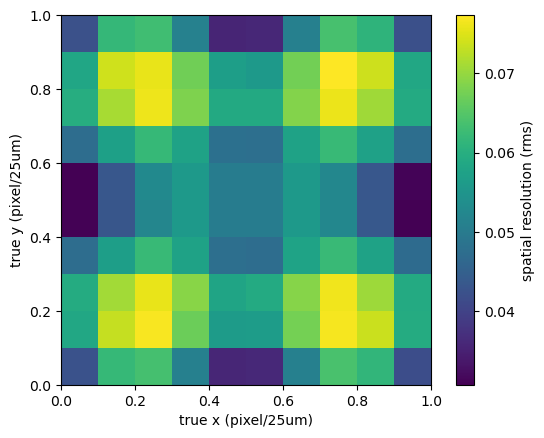

In [17]:
### spatial resolution in 5x5 grid
nBins = 10
rmsArray = np.zeros((nBins, nBins), dtype=float)
x = np.array(x)%1
y = np.array(y)%1
for i in range(nBins):
    for j in range(nBins):
        xMask = (np.array(x) >= i/nBins) & (np.array(x) < (i+1)/nBins)
        yMask = (np.array(y) >= j/nBins) & (np.array(y) < (j+1)/nBins)
        xyMask = xMask & yMask
        residuls_x_ij = np.array(residuls_x)[xyMask]
        residuls_y_ij = np.array(residuls_y)[xyMask]
        rmsArray[i, j] = np.sqrt(np.mean(residuls_x_ij**2 + residuls_y_ij**2))
plt.imshow(rmsArray, origin='lower', extent=(0,1,0,1))
plt.xlabel('true x (pixel/25um)')
plt.ylabel('true y (pixel/25um)')
plt.colorbar(label='spatial resolution (rms)')


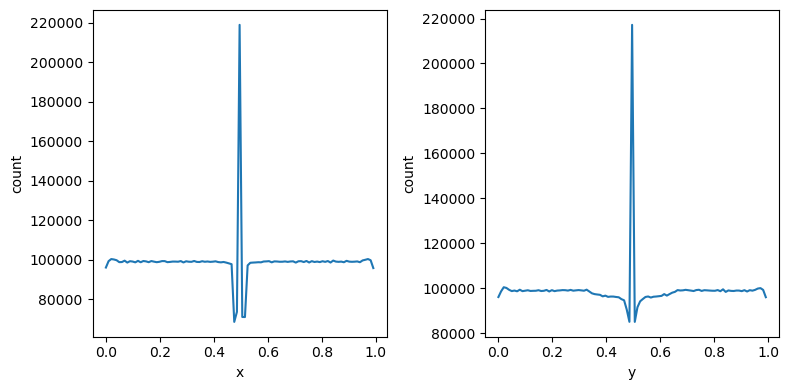

In [18]:
### project along x and y axis
nBins = interpolated_2d.shape[0]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(np.arange(nBins)/nBins, np.sum(interpolated_2d, axis=1))
plt.xlabel('x')
plt.ylabel('count')
plt.subplot(1,2,2)
plt.plot(np.arange(nBins)/nBins, np.sum(interpolated_2d, axis=0))
plt.xlabel('y')
plt.ylabel('count')
plt.tight_layout()
plt.show()

ground truth: (0.7637, 0.3112) (pixel), z=583.5157 (um)
interpolated: (0.6298, 0.4425)


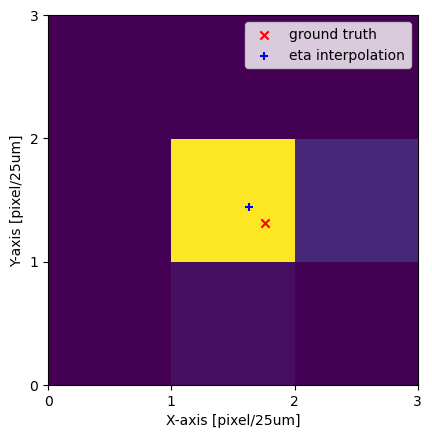

In [19]:
### plot one sample
sampleFile = sampleFileList[0]
idx = 15
# idx = 1
samples = np.load(sampleFile)['samples'][:, 1:-1, 1:-1]
sample = samples[idx]
labels = np.load(sampleFile)['labels']
label_x, label_y = labels[idx, 0], labels[idx, 1]
label_z = labels[idx, 2]
sum = np.sum(sample, axis=(-1,-2))
qc_x = np.sum(sample, axis=0) * np.arange(-1, 2)
qc_x = np.sum(qc_x)/sum + 0.5
qc_y = np.sum(sample, axis=1) * np.arange(-1, 2)
qc_y = np.sum(qc_y)/sum + 0.5
print(f'ground truth: ({label_x-2:.4f}, {label_y-2:.4f}) (pixel), z={label_z:.4f} (um)')
interp_x, interp_y = bilinear_xy_lookup(qc_x, qc_y, X_tab, Y_tab)
# interp_x, interp_y = xy_lookup(qc_x, qc_y, X_tab, Y_tab)
plt.imshow(sample, origin='lower', extent=(0,3,0,3))
### x and y title
plt.xlabel('X-axis [pixel/25um]')
plt.ylabel('Y-axis [pixel/25um]')
### tick labels from 0 to 3
plt.xticks(np.arange(0, 4, 1))
plt.yticks(np.arange(0, 4, 1))
plt.scatter([label_x-1], [label_y-1], color='red', marker='x', label='ground truth')
print(f'interpolated: ({interp_x:.4f}, {interp_y:.4f})')
plt.scatter([interp_x+1], [interp_y+1], color='blue', marker='+', label='eta interpolation')
plt.legend()
# plt.scatter([qc_x+0.5], [qc_y+0.5], color='green', marker='o')